In [1]:
from sklearn.model_selection import cross_val_score
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pprint import pprint

import warnings
warnings.filterwarnings('ignore')

# set random seed
seed_val = 1160
np.random.seed(seed_val)

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib

import matplotlib.pyplot as plt
from scipy.stats import skew
from scipy.stats.stats import pearsonr

In [3]:
# Targeted directory
target_fold_dir = 'fold1'
# import the fold1 data
X_train_full = pd.read_csv(f'{target_fold_dir}/train.csv', index_col='PID')
X_train = X_train_full.iloc[:, 1:-1] # exclude the first column and the last two columns
y_train = np.log(X_train_full.iloc[:, -1])

# import the test data
X_test_full = pd.read_csv(f'{target_fold_dir}/test.csv', index_col='PID')
test_data_y = pd.read_csv(f'{target_fold_dir}/test_y.csv', index_col='PID')

X_test = X_test_full.iloc[:, 1:] # exclude the first column and the last two columns
y_test = np.log(test_data_y.iloc[:, -1])


In [4]:
X_train_processed = X_train.copy()
X_test_processed = X_test.copy()
y_train_processed = y_train.copy()
y_test_processed = y_test.copy()

In [5]:
def clean(df: pd.DataFrame) -> pd.DataFrame:
    max_year = 2011 # the max year of the training data
    # corrupted Garage_Yr_Blt = less than Year_Built or nan
    df['Garage_Yr_Blt'] = df['Garage_Yr_Blt'].apply(lambda x: x if x <= max_year else np.nan)
    df['Garage_Yr_Blt'] = df['Garage_Yr_Blt'].fillna(df['Year_Built'])
    return df

X_train_processed = clean(X_train_processed)
X_test_processed = clean(X_test_processed)

Drop 19 rows


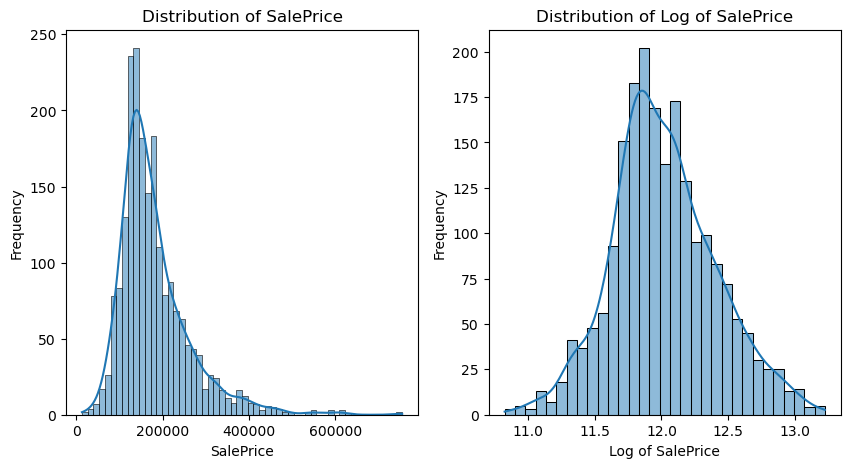

In [6]:
# plot the sales price distribution (original, log)

y_train_original = X_train_full.iloc[:, -1]

# drop the rows with extreme price larger
mean = y_train.mean()
std = y_train.std()    
rows_to_drop = y_train[(y_train > mean + 3 * std) | (y_train < mean - 3 * std)].index
print(f'Drop {len(rows_to_drop)} rows')
X_train_processed = X_train_processed.drop(index=rows_to_drop)
y_train_processed = y_train_processed.drop(index=rows_to_drop)


fig, axs = plt.subplots(1, 2, figsize=(10, 5))
sns.histplot(y_train_original, kde=True, ax=axs[0]) 
axs[0].set_title('Distribution of SalePrice')
axs[0].set_xlabel('SalePrice')
axs[0].set_ylabel('Frequency')

sns.histplot(y_train_processed, kde=True, ax=axs[1]) 
axs[1].set_title('Distribution of Log of SalePrice')
axs[1].set_xlabel('Log of SalePrice')
axs[1].set_ylabel('Frequency')

plt.show()

In [7]:
#log transform skewed numeric features:
numeric_feats = X_train_processed.dtypes[X_train_processed.dtypes != "object"].index

skewed_feats = X_train_processed[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index

X_train_processed[skewed_feats] = np.log1p(X_train_processed[skewed_feats])
X_test_processed[skewed_feats] = np.log1p(X_test_processed[skewed_feats])

#### Categorical features

In [8]:
train_c=X_train_processed[[c for c in X_train_processed.columns if X_train_processed[c].dtypes=='O']].copy()
test_c=X_test_processed[[c for c in X_test_processed.columns if X_test_processed[c].dtypes=='O']].copy()

In [9]:
print(train_c.head())
print(test_c.head())

                          MS_Zoning Street            Alley  \
PID                                                           
526350040  Residential_High_Density   Pave  No_Alley_Access   
526351010   Residential_Low_Density   Pave  No_Alley_Access   
527105010   Residential_Low_Density   Pave  No_Alley_Access   
527105030   Residential_Low_Density   Pave  No_Alley_Access   
527127150   Residential_Low_Density   Pave  No_Alley_Access   

                    Lot_Shape Land_Contour Utilities Lot_Config Land_Slope  \
PID                                                                          
526350040             Regular          Lvl    AllPub     Inside        Gtl   
526351010  Slightly_Irregular          Lvl    AllPub     Corner        Gtl   
527105010  Slightly_Irregular          Lvl    AllPub     Inside        Gtl   
527105030  Slightly_Irregular          Lvl    AllPub     Inside        Gtl   
527127150             Regular          Lvl    AllPub     Inside        Gtl   

          N

<Axes: xlabel='None', ylabel='None'>

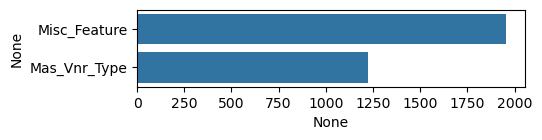

In [13]:
# print(train_c.shape)
fig=plt.figure(figsize=(5,1))
train_null=train_c.isnull().sum()[train_c.isnull().sum()!=0].sort_values(ascending=False)
sns.barplot(y=train_null.index,x=train_null)

In [16]:
# dropping the rows with missing values in the categorical features
X_train_processed = X_train_processed.drop(columns=train_null.index)
X_test_processed = X_test_processed.drop(columns=train_null.index)

In [17]:
X_train_processed.columns


Index(['MS_Zoning', 'Lot_Frontage', 'Lot_Area', 'Street', 'Alley', 'Lot_Shape',
       'Land_Contour', 'Utilities', 'Lot_Config', 'Land_Slope', 'Neighborhood',
       'Condition_1', 'Condition_2', 'Bldg_Type', 'House_Style',
       'Overall_Qual', 'Overall_Cond', 'Year_Built', 'Year_Remod_Add',
       'Roof_Style', 'Roof_Matl', 'Exterior_1st', 'Exterior_2nd',
       'Mas_Vnr_Area', 'Exter_Qual', 'Exter_Cond', 'Foundation', 'Bsmt_Qual',
       'Bsmt_Cond', 'Bsmt_Exposure', 'BsmtFin_Type_1', 'BsmtFin_SF_1',
       'BsmtFin_Type_2', 'BsmtFin_SF_2', 'Bsmt_Unf_SF', 'Total_Bsmt_SF',
       'Heating', 'Heating_QC', 'Central_Air', 'Electrical', 'First_Flr_SF',
       'Second_Flr_SF', 'Low_Qual_Fin_SF', 'Gr_Liv_Area', 'Bsmt_Full_Bath',
       'Bsmt_Half_Bath', 'Full_Bath', 'Half_Bath', 'Bedroom_AbvGr',
       'Kitchen_AbvGr', 'Kitchen_Qual', 'TotRms_AbvGrd', 'Functional',
       'Fireplaces', 'Fireplace_Qu', 'Garage_Type', 'Garage_Yr_Blt',
       'Garage_Finish', 'Garage_Cars', 'Garage_Area', '

In [19]:
def label_encoding(df):
    le = LabelEncoder()
    for col in df.select_dtypes(exclude=['number']).columns:
        df[col] = le.fit_transform(df[col])
    return df

In [20]:
# get dummy variables for the categorical features
# X_train_processed = pd.get_dummies(X_train_processed)
# X_test_processed = pd.get_dummies(X_test_processed)
X_train_processed = label_encoding(X_train_processed)
X_test_processed = label_encoding(X_test_processed)

In [21]:
# filling NAN with the mean of the column
X_train_processed = X_train_processed.fillna(X_train_processed.mean())
X_test_processed = X_test_processed.fillna(X_test_processed.mean())


In [22]:
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score

def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, X_train_processed, y_train_processed, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

def rmse(y_test, y_pred):
    return np.sqrt(np.mean((y_test - y_pred) ** 2))

In [23]:

model_ridge = Ridge()

Text(0, 0.5, 'rmse')

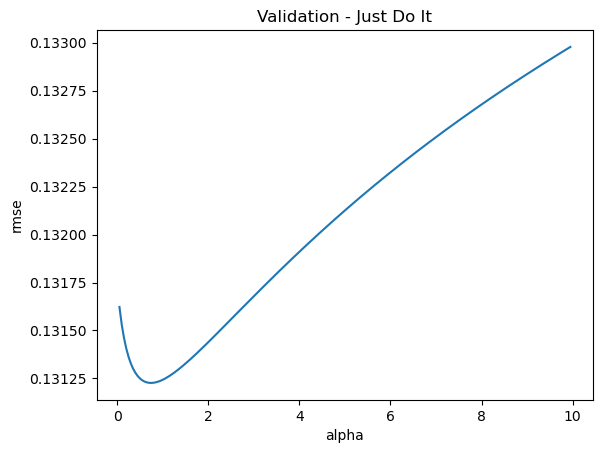

In [24]:
alphas = np.arange(0.05, 10, 0.05)
cv_ridge = [rmse_cv(Ridge(alpha=alpha)).mean()
            for alpha in alphas]
cv_ridge = pd.Series(cv_ridge, index=alphas)
cv_ridge.plot(title="Validation - Just Do It")
plt.xlabel("alpha")
plt.ylabel("rmse")

In [25]:
cv_ridge.min()

0.13122670570887446

In [26]:
model_lasso = LassoCV(alphas = [1, 0.1, 0.001, 0.0005])
model_lasso.fit(X_train_processed, y_train_processed)
rmse_cv(model_lasso).mean()

0.13110789158064906

In [27]:
# testing the model on the test data
y_pred_lasso = model_lasso.predict(X_test_processed)
rmse(y_test_processed, y_pred_lasso)

0.16614739734488543

In [28]:
coef = pd.Series(model_lasso.coef_, index = X_train_processed.columns)
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Lasso picked 66 variables and eliminated the other 12 variables


Text(0.5, 1.0, 'Coefficients in the Lasso Model')

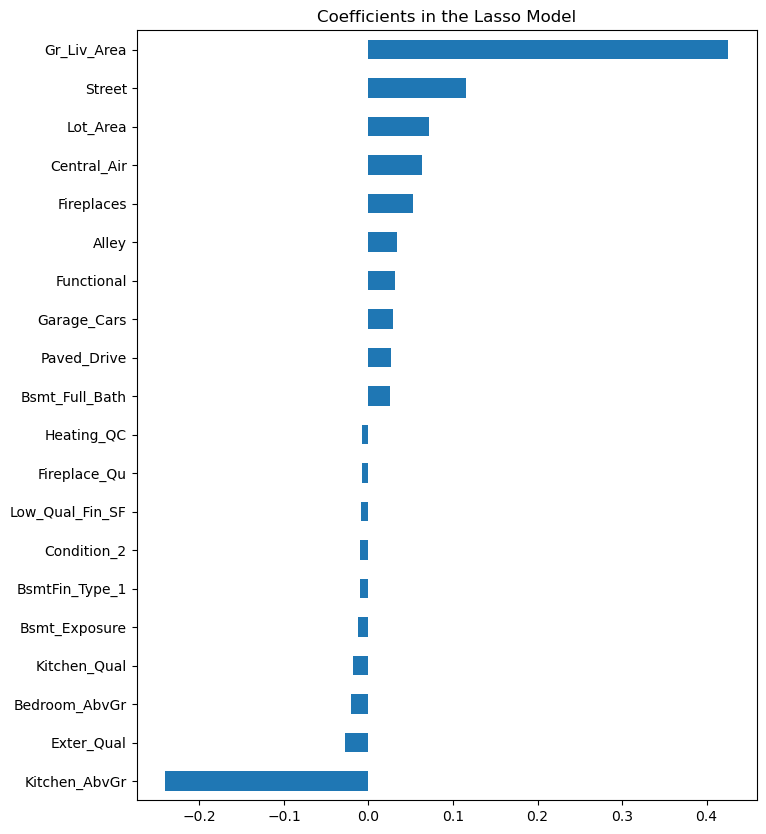

In [29]:
imp_coef = pd.concat([coef.sort_values().head(10),
                     coef.sort_values().tail(10)])
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")

<Axes: xlabel='preds', ylabel='residuals'>

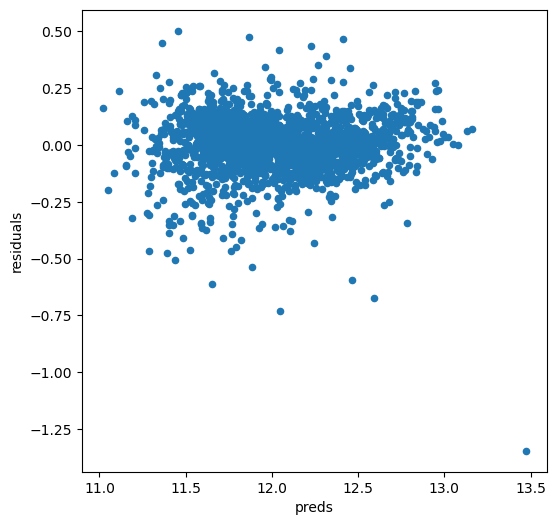

In [30]:
#let's look at the residuals as well:
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)

preds = pd.DataFrame({"preds":model_lasso.predict(X_train_processed), "true":y_train_processed})
preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "residuals",kind = "scatter")

<Axes: >

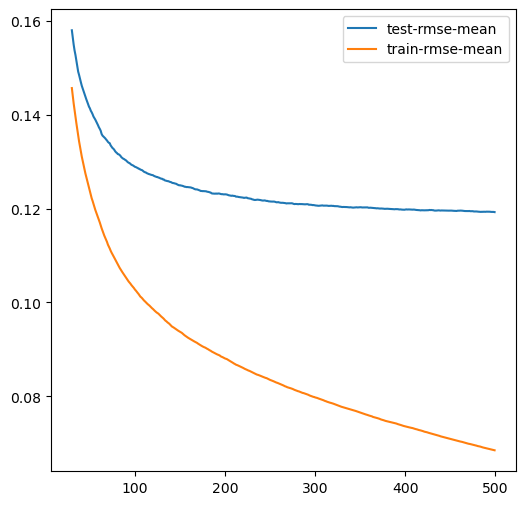

In [31]:
import xgboost as xgb

dtrain = xgb.DMatrix(X_train_processed, label = y_train_processed)
dtest = xgb.DMatrix(X_test_processed)

params = {"max_depth":2, "eta":0.1}
model = xgb.cv(params, dtrain,  num_boost_round=500, early_stopping_rounds=100)

model.loc[30:,["test-rmse-mean", "train-rmse-mean"]].plot()

In [32]:
model_xgb = xgb.XGBRegressor(n_estimators=360, max_depth=2, learning_rate=0.1) #the params were tuned using xgb.cv
model_xgb.fit(X_train_processed, y_train_processed)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=2, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=360, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [33]:
xgb_preds = model_xgb.predict(X_test_processed)
lasso_preds = model_lasso.predict(X_test_processed)

# rmse of the xgb and lasso models
print(rmse(y_test_processed, xgb_preds))
print(rmse(y_test_processed, lasso_preds))

0.1209802921139889
0.16614739734488543


<Axes: xlabel='xgb', ylabel='lasso'>

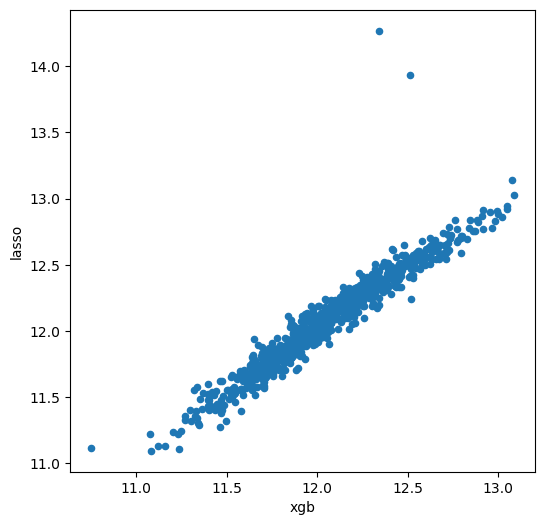

In [34]:
predictions = pd.DataFrame({"xgb":xgb_preds, "lasso":lasso_preds})
predictions.plot(x = "xgb", y = "lasso", kind = "scatter")

In [35]:
preds = 0.7*lasso_preds + 0.3*xgb_preds

In [36]:
print(rmse(y_test_processed, preds))

0.14471201811756873
